<a href="https://colab.research.google.com/github/sbbwoy/calsci/blob/main/HW2_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 과제 2. CNN : CIFAR-10 (다중분류)

> 2029017 박지연    
 계산과학 프로그래밍 및 실습


---


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

In [ ]:
# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Current device is', device)

# for reproducibility
torch.manual_seed(2023)
if device == 'cuda':
    torch.cuda.manual_seed_all(2023)

Current device is cuda


## 1. Data

CIFAR-10

In [ ]:
# Cifar10 dataset

cifar10 = datasets.CIFAR10(root='./data', train=True, download=True,
                           transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:08<00:00, 20720227.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
len(cifar10)

50000

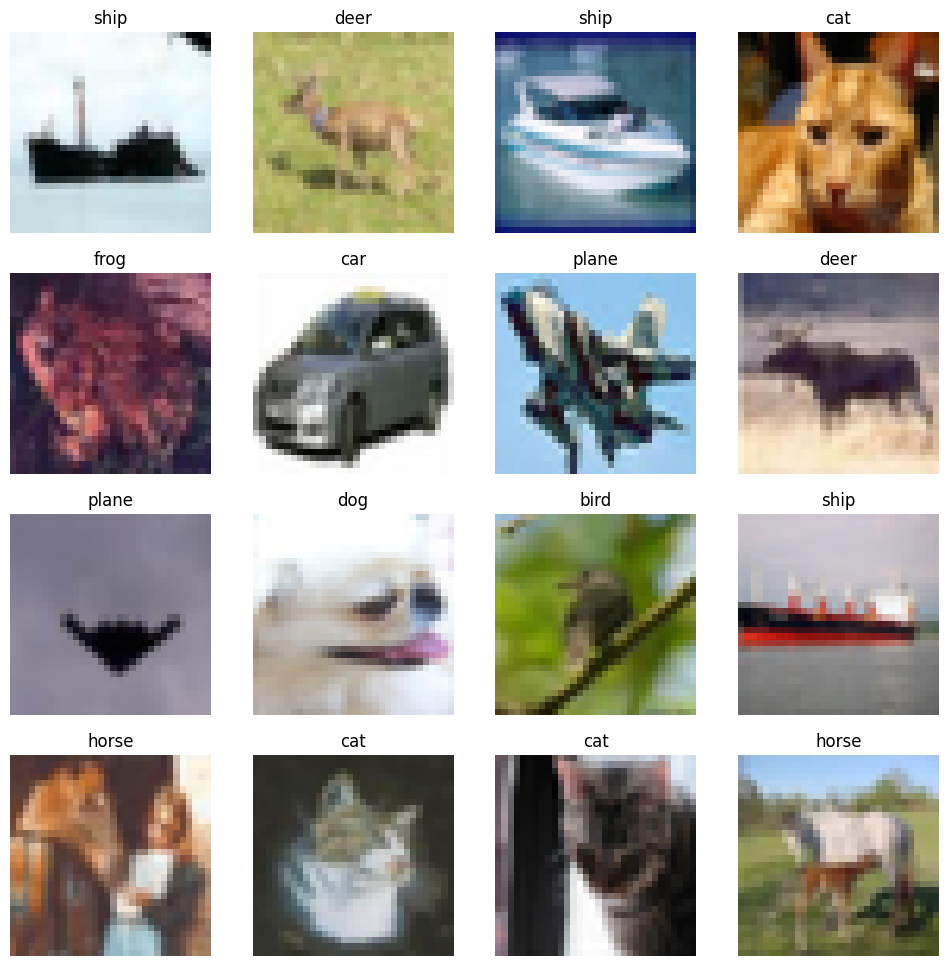

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 이미지를 보여주기 위한 함수
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

figure = plt.figure(figsize=(12, 12))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(cifar10), size=(1,)).item()
    img, label = cifar10[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    imshow(img)
plt.show()

In [ ]:
batch_size = 16

train_loader = DataLoader(cifar10, batch_size=batch_size, shuffle=True)

# 배치 단위로 평균과 표준 편차 계산
mean_list = []
std_list = []

for batch in train_loader:
    images, _ = batch
    batch_mean = torch.mean(images, dim=(0, 2, 3))
    batch_std = torch.std(images, dim=(0, 2, 3))

    mean_list.append(batch_mean)
    std_list.append(batch_std)

# 전체 데이터셋에 대한 평균과 표준 편차 계산
cifar10_mean = torch.mean(torch.stack(mean_list), dim=0)
cifar10_std = torch.mean(torch.stack(std_list), dim=0)

print("평균:", cifar10_mean)
print("표준 편차:", cifar10_std)

평균: tensor([0.4914, 0.4822, 0.4465])
표준 편차: tensor([0.2443, 0.2408, 0.2581])


In [ ]:
trans_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 랜덤으로 이미지를 수평으로 뒤집기
    transforms.RandomRotation(10),  # 랜덤으로 이미지를 최대 10도 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 랜덤으로 밝기, 대조, 채도, 색상 조절
    transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])
trans_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

In [ ]:
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=trans_test)

Files already downloaded and verified


In [ ]:
# train, validation set split
train_data, val_data = torch.utils.data.random_split(cifar10, [40000, 10000])

In [ ]:
from copy import deepcopy

tr1_cifar10 = deepcopy(train_data)
tr1_cifar10.dataset.transform = trans_train

In [ ]:
transform2 = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomVerticalFlip(),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])
tr2_cifar10 = deepcopy(train_data)
tr2_cifar10.dataset.transform = transform2

In [ ]:
train_data = ConcatDataset([train_data, tr1_cifar10, tr2_cifar10])

In [ ]:
# print number of training/validation/test data
print('The number of training data:     ', len(train_data))
print('The number of validataion data:  ', len(val_data))
print('The number of test data:         ', len(cifar_test))

The number of training data:      120000
The number of validataion data:   10000
The number of test data:          10000


8 ship


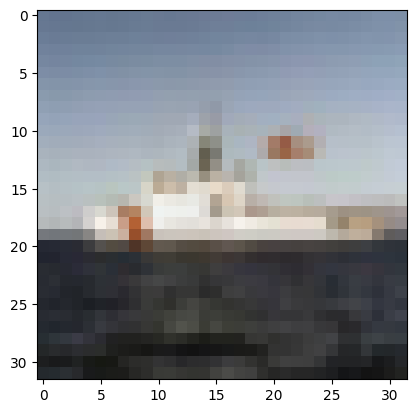

In [ ]:
# train_data 첫번째 이미지 및 클래스 출력
img, label = train_data[0]
imshow(img)
print(label, classes[label])

In [ ]:
# image size 확인
print(img.shape)

torch.Size([3, 32, 32])


In [ ]:
# set hyperparameters
learning_rate = 0.001
epochs = 500

In [ ]:
# train, validation, test dataset loader (for mini-batch training)
# For test dataset loader, set 'batch_size=len(test_data), shuffle=False'.

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=cifar_test, batch_size=len(cifar_test), shuffle=False)

## 2. Model

In [ ]:
import torch.nn.functional as F

###내가만든쓰레기~

In [ ]:
# CNN Model class
class CNNWithL1(nn.Module):
    def __init__(self):
        super(CNNWithL1, self).__init__()
        # L1   (?, 3, 32, 32)
        # Conv (?, 32, 32, 32)
        # Pool (?, 32, 16, 16)
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        # L2   (?, 32, 16, 16)
        # Conv (?, 32, 16, 16)
        # Pool (?, 32, 8, 8)
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, stride=2)
            )
        # L3   (?, 32, 8, 8)
        # Conv (?, 32, 8, 8)
        # Pool (?, 32, 4, 4)
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, stride=2)
            )

        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, stride=2)
            )
        self.dropout = nn.Dropout(0.5)

        # FC Layer
        self.fc = nn.Linear(256*2*2, 1024)
        nn.init.kaiming_normal_(self.fc.weight)

        self.fc2 = nn.Linear(1024, 512)
        self.batch_norm_fc2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 10)


    def forward(self, x, lambda_l1=0.001):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)

        # L1 regularization
        l1_penalty = 0
        for param in self.parameters():
            l1_penalty += torch.norm(param, 1)

        out = self.fc(out)
        out = self.fc2(out)
        out = self.batch_norm_fc2(out)
        out = self.fc3(out)

        out = F.softmax(out, dim=1)

        return out + lambda_l1 * l1_penalty

###CNNWithTree

In [ ]:
class Basic(nn.Module):
    expansion = 1

    def __init__(self, in_planes=3, planes=32, stride=1):
        super(Basic, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x) #shortcut이 뭐지
        out = F.relu(out)

        return out

class Root(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(Root, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=1, padding=(kernel_size-1)//2, bias=False
            )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = torch.cat(x, 1) #cat 뭐지
        out = self.conv(out)
        out = self.bn(out)
        out = F.relu(out)

        return out

class Tree(nn.Module):
    def __init__(self, block, in_channels, out_channels, level=1, stride=1):
        super(Tree, self).__init__()
        self.root = Root(2*out_channels, out_channels) #왜 ?
        if level == 1:
            self.left = block(in_channels, out_channels, stride=stride)
            self.right = block(out_channels, out_channels, stride=1) #왜 1 고정이지
        else:
            self.left = Tree(block, in_channels, out_channels, level=level-1, stride=stride)
            self.right = Tree(block, out_channels, out_channels, level=level-1, stride=1)


    def forward(self, x):
        out1 = self.left(x)
        out2 = self.right(out1)
        out = self.root([out1, out2])
        return out

class CNNWithTree(nn.Module):
    def __init__(self, block=Basic, num_classes=10):
        super(CNNWithTree, self).__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        #self.layer3 = Tree(block,  32,  64, level=1, stride=1)
        self.layer4 = Tree(block,  64, 128, level=2, stride=2)
        self.layer5 = Tree(block, 128, 256, level=2, stride=2)
        self.layer6 = Tree(block, 256, 512, level=1, stride=2)
        self.linear = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        lambda_l1 = 0.001

        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        #out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)     #뭐지
        out = self.linear(out)
        out = F.softmax(out, dim=1)

        # L1 regularization
        l1_penalty = 0
        for param in self.parameters():
            l1_penalty += torch.norm(param, 1)

        return out + lambda_l1 * l1_penalty

layer3 넣고 l1 규제까지 해서 돌리면 모델이 돌아가나... l2규제라고 다를 건 없는 거 같음... 오늘 res net 수업 들으면서 코드짜봐야지...

Nesterov Acceleated Gradient (NAG)는 momentum을 개선한 알고리즘으로, 현재 위치가 아닌 가까운 미래의 위치에서 가중치를 계산함. torch.optim.SGD(nesterov=True)로 구현

In [ ]:
# instantiate CNN model
model = CNNWithTree().to(device)

# define loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True) #weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.8)

In [ ]:
print(model)

CNNWithTree(
  (base): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Tree(
    (root): Root(
      (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (left): Tree(
      (root): Root(
        (conv): Conv2d(256, 128, kernel_siz

##모델성능테스트

In [ ]:
import torch
import numpy as np
from torch import nn
import torch.autograd.profiler as profiler

In [ ]:
model = CNNWithTree().cuda()
input = torch.rand(1, 3, 32, 32).cuda()

# 워밍업(warm-up)
model(input)

with profiler.profile(with_stack=True, profile_memory=True) as prof:
    out = model(input)

print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=5))

## 3. Training

In [ ]:
train_batch = len(train_loader)
val_batch = len(val_loader)
print(train_batch, val_batch, sep='\n')

7500
625


- 그냥 모델 구조 자체를 갈아엎어야되는 문제임... 일단 B3랑 DLA 모델 분석해서 비슷하게라도 만들어보는 게 목표
- 지금 train < val, test 상태인데 이게 train data에 argmented data가 너무 많아서 (original:argmented = 20000:40000) 줄이는 게 필요할수도...  
- SimpleDLA를 참조하는 것도 ㄱㅊ은듯.. DLA 코드가 너무너무너무너무 많음

- B3의 경우 train:test = 40000:10000에 epoch 10 lr 0.001로 87%까지 나옴... 장난치나

- 1115) 데이터를 더 늘려야겠다... bias도 true 하고 돌려보기

bias

- bias는 해당 레이어의 모든 뉴런에 더해지는 상수로, 모델이 입력 데이터를 더 잘 적합하게 만든다.
- 표현 능력 향상, 원점에서의 offset(=입력 특성이 0일 때도 뉴런이 활성화)

bias=False(0)의 이유?
- 모델 파라미터 수 감소 -> 모델의 복잡도를 낮추고 과적합을 예방
- 계산 효율성 -> 예측 속도 향상

집 가서 https://tutorials.pytorch.kr/beginner/profiler.html 이거 해보기

In [ ]:
# train model
# epoch마다 training/validation loss와 accuracy 출력 및 loss와 accuracy 그래프 그리기 위한 list 만들기

print('Learning started.')


train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

best_val_loss = 10**9   # 큰 값으로 초기값 가정
patience_limit = 3    # 몇 번의 epoch까지 지켜볼지를 결정
patience_check = 0    # 현재 몇 epoch 연속으로 loss 개선 안되었는지 기록

for epoch in range(epochs):
    # training
    train_loss = 0
    correct = 0

    for X, Y in train_loader:

        X = X.to(device)
        Y = Y.to(device)


        Y_pred = model.forward(X)
        loss = criterion(Y_pred, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss / train_batch

        correct_prediction = torch.argmax(Y_pred, 1) == Y
        correct += correct_prediction.sum()

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    train_acc = (100*correct/len(train_loader.dataset))
    train_acc_list.append(train_acc.item())
    train_loss_list.append(train_loss.item())

    # validation
    with torch.no_grad():
        val_loss = 0
        correct = 0

        for X, Y in val_loader:
            X_val = X.to(device)
            Y_val = Y.to(device)

            Y_pred = model.forward(X_val)
            loss = criterion(Y_pred, Y_val)

            val_loss += loss / val_batch

            correct_prediction = torch.argmax(Y_pred, 1) == Y_val
            correct += correct_prediction.sum()

        val_acc = (100*correct/len(val_loader.dataset))
        val_acc_list.append(val_acc.item())
        val_loss_list.append(val_loss.item())


    print("[Epoch %2d] loss %.4f  acc %.2f, val loss %.4f  val acc %.2f  Learning Rate %.4f  patience %d"
          % (epoch+1, train_loss, train_acc, val_loss, val_acc, current_lr, patience_check))

    # early stopping
    if val_loss > best_val_loss: # loss가 개선되지 않은 경우
        patience_check += 1
        if patience_check >= patience_limit: # early stopping 조건 만족 시 조기 종료
            print('Early Stopping!')
            break
    else: # loss가 개선된 경우
        best_val_loss = val_loss
        patience_check = 0

print('Learning Finished!')

Learning started.
[Epoch  1] loss 2.1774  acc 27.15, val loss 2.0599  val acc 39.77  Learning Rate 0.0010  patience 0
[Epoch  2] loss 2.0470  acc 41.06, val loss 1.9239  val acc 54.04  Learning Rate 0.0010  patience 0
[Epoch  3] loss 1.9629  acc 49.68, val loss 1.8579  val acc 60.77  Learning Rate 0.0010  patience 0
[Epoch  4] loss 1.9102  acc 54.99, val loss 1.8150  val acc 64.72  Learning Rate 0.0010  patience 0
[Epoch  5] loss 1.8661  acc 59.65, val loss 1.7671  val acc 69.75  Learning Rate 0.0010  patience 0
[Epoch  6] loss 1.8301  acc 63.17, val loss 1.7493  val acc 71.61  Learning Rate 0.0010  patience 0
[Epoch  7] loss 1.8057  acc 65.65, val loss 1.7091  val acc 75.48  Learning Rate 0.0010  patience 0
[Epoch  8] loss 1.7871  acc 67.51, val loss 1.7012  val acc 76.13  Learning Rate 0.0010  patience 0
[Epoch  9] loss 1.7704  acc 69.24, val loss 1.6957  val acc 76.57  Learning Rate 0.0010  patience 0
[Epoch 10] loss 1.7561  acc 70.56, val loss 1.6776  val acc 78.65  Learning Rate 0

- l1 reg, 0.8: [Epoch 28] loss 1.5142  acc 95.52, val loss 1.7052  val acc 75.79
- 0.7: [Epoch 21] loss 1.5357  acc 93.35, val loss 1.7078  val acc 75.73.
- 0.01, 5000: [Epoch 18] loss 1.5560  acc 91.24, val loss 1.7040  val acc 76.09

- l2 reg: [Epoch 18] loss 1.5531  acc 91.49, val loss 1.7043  val acc 75.85

- NAG: [Epoch 24] loss 1.5368  acc 92.63, val loss 1.6966  val acc 76.39

- Rprop, Adam, Nadam 쓰레기

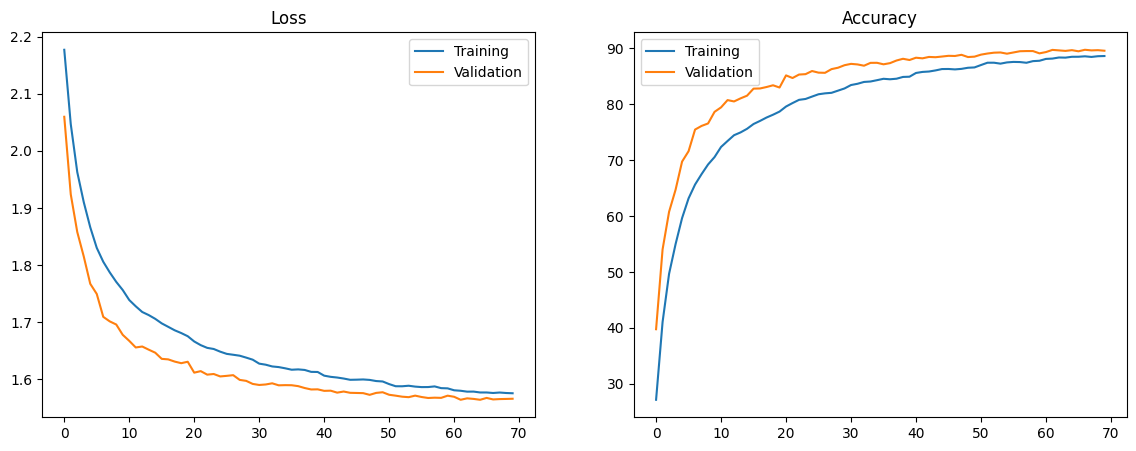

In [ ]:
# plot train/validation loss and accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.plot(range(len(train_loss_list)), train_loss_list, range(len(val_loss_list)), val_loss_list)
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(range(len(train_acc_list)), train_acc_list, range(len(val_acc_list)),val_acc_list)
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.show()

## 4. Test Model

In [ ]:
# Test model and print test accuracy
with torch.no_grad():
    correct = 0
    # Test the model using test sets
    for X, Y in test_loader:
        X_test = X.to(device)
        Y_test = Y.to(device)

        Y_pred = model.forward(X_test)
        prediction = torch.argmax(Y_pred, 1)
        correct_prediction = prediction == Y_test
        correct += correct_prediction.sum()

    accuracy = 100*correct/len(test_loader.dataset)
    print('Test set Accuracy: %.2f' % (accuracy))

Test set Accuracy: 89.81


observed_y:  ['dog', 'bird', 'bird', 'deer', 'bird']
predicted_y:  ['deer', 'cat', 'ship', 'cat', 'frog']


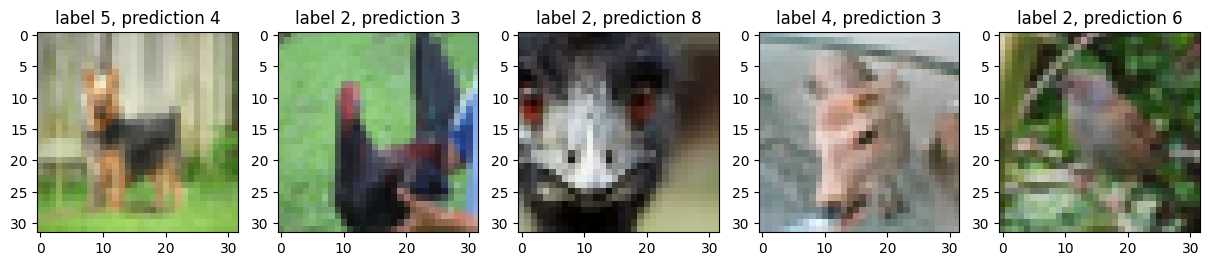

In [ ]:
# 잘못 예측한 5개 이미지 보기 (진짜 라벨과 예측 라벨 같이 출력)
false_list = []
for i, c in enumerate(correct_prediction):
    if c == False:
        false_list.append(i)

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(cifar_test.data[false_list[i]], cmap='gray')
    plt.title('label %d, prediction %d'
              %(cifar_test.targets[false_list[i]], prediction[false_list[i]]))

print('observed_y: ', [classes[cifar_test.targets[i]] for i in false_list][:5])
print('predicted_y: ', [classes[prediction[i]] for i in false_list][:5])
plt.show()

## 5. Save Model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CNNWithTree_weight2.pt')

In [ ]:
'''
my_model = CNNWithTree().to(device)
my_model.load_state_dict(torch.load('/content/drive/MyDrive/CNNWithTree_weight2.pt'))
my_model.eval()
'''

CNNWithTree(
  (base): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Tree(
    (root): Root(
      (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (left): Tree(
      (root): Root(
        (conv): Conv2d(256, 128, kernel_siz